In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local')

sc.stop()
sc = SparkContext(conf = conf)
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
#cargar la base de datos
df = spark.read.option('header', 'true').csv('carpetas-de-investigacion-pgj-cdmx.csv', sep = ';')

In [3]:
df.printSchema()

root
 |-- Año: string (nullable = true)
 |-- Mes: string (nullable = true)
 |-- Alcaldía: string (nullable = true)
 |-- Categoría de delito: string (nullable = true)
 |-- Delito: string (nullable = true)
 |-- Agencia: string (nullable = true)
 |-- Unidad de investigación: string (nullable = true)
 |-- Fecha inicio: string (nullable = true)
 |-- Fiscalía: string (nullable = true)
 |-- Calle1: string (nullable = true)
 |-- Calle2: string (nullable = true)
 |-- Colonia: string (nullable = true)
 |-- Latitud: string (nullable = true)
 |-- Longitud: string (nullable = true)
 |-- Mes y año: string (nullable = true)
 |-- Geopoint: string (nullable = true)



In [4]:
df1 = df.select(['Alcaldía', 'Mes y año'])
df1 = df1.filter(df1['Alcaldía'] == 'IZTACALCO')#filtra por alcaldía

df1.show()

+---------+---------+
| Alcaldía|Mes y año|
+---------+---------+
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2016-11|
|IZTACALCO|  2016-11|
|IZTACALCO|  2016-11|
|IZTACALCO|  2016-11|
|IZTACALCO|  2017-03|
+---------+---------+
only showing top 20 rows



In [5]:
time_df = df1.groupby("Mes y año").count()#agrupa por mes y año para contar delitos
time_df.show()

+---------+-----+
|Mes y año|count|
+---------+-----+
|  2018-10| 1031|
|  2017-09|  871|
|  2017-10|  943|
|  2016-02|  572|
|  2017-05|  800|
|  2018-06|  873|
|  2017-11|  909|
|  2018-03|  939|
|  2017-03|  777|
|  2018-02|  853|
|  2016-12|  686|
|  2017-08|  888|
|  2016-09|  744|
|  2016-03|  676|
|  2017-06|  789|
|  2016-10|  730|
|  2017-02|  667|
|  2017-04|  697|
|  2018-05|  904|
|  2018-08| 1027|
+---------+-----+
only showing top 20 rows



In [6]:
import pandas as pd

time_pd = time_df.toPandas()#importa el dataframe a pandas
time_pd.set_index('Mes y año', inplace = True)#cambia índice por columna mes y año
time_pd.head()

,count
Mes y año,
2018-10,1031
2017-09,871
2017-10,943
2016-02,572
2017-05,800


In [7]:
time_pd = time_pd.sort_values(by = "Mes y año", ascending = True)
time_pd.drop('01/2019', inplace = True)#quita fila 01/2019 pues mete ruido al ser sólo un delito
time_pd.drop('feb-19', inplace = True)
time_pd.head()

,count
Mes y año,
2016-01,633
2016-02,572
2016-03,676
2016-04,768
2016-05,705


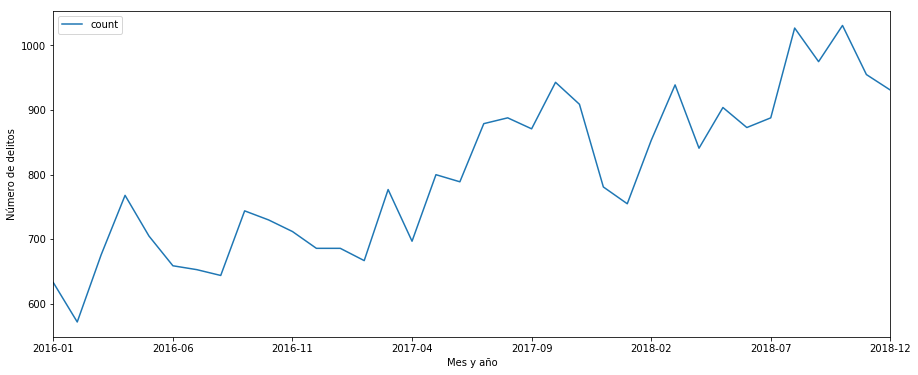

In [9]:
import matplotlib.pyplot as plt

time_pd.plot(figsize = (15, 6))
plt.ylabel('Número de delitos')
plt.show()

In [10]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
#from statsmodels import api as sm
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')
p = q = range(0, 4)#define orden p y q del modelo
pq = list(itertools.product(p, q))#lista de posibles combinaciones de p y q
print("Examples of parameter combinations for ARMA")
print("ARMA {}".format(pq[1]))
print("ARMA {}".format(pq[2]))
print("ARMA {}".format(pq[3]))

Examples of parameter combinations for ARMA
ARMA (0, 1)
ARMA (0, 2)
ARMA (0, 3)


In [11]:
time_pd.index = pd.DatetimeIndex(time_pd.index)#cambia índice del dataframe a un índice temporal

#muestra el criterio de información Akaike
#es un estimador relativo a la calidad de modelos estadísticos
for param in pq:
    try:
        mod = ARMA(time_pd, order = param)
        
        results_test = mod.fit()
        #muestra resultados y busca el de menor valor
        print("ARMA{}: - AIC:{}".format(param, results_test.aic))
    except:
        continue

ARMA(0, 0): - AIC:450.9697869368542
ARMA(0, 1): - AIC:431.4524498197224
ARMA(0, 2): - AIC:422.6253280725354
ARMA(0, 3): - AIC:420.62685028287126
ARMA(1, 0): - AIC:411.32234184576174
ARMA(1, 1): - AIC:747.751809595002
ARMA(1, 2): - AIC:467.30844581323373
ARMA(2, 0): - AIC:412.4686805641833
ARMA(2, 1): - AIC:413.5805024398938
ARMA(2, 2): - AIC:419.1222144518083
ARMA(3, 0): - AIC:414.2513680567587
ARMA(3, 1): - AIC:415.51979729115476
ARMA(3, 2): - AIC:413.865113678315


In [12]:
model = ARMA(time_pd, order = (1, 0))#con el menor valor de aic, ajusta modelo a los datos
results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                   36
Model:                     ARMA(1, 0)   Log Likelihood                -202.661
Method:                       css-mle   S.D. of innovations             66.225
Date:                Sat, 13 Apr 2019   AIC                            411.322
Time:                        10:35:11   BIC                            416.073
Sample:                    01-01-2016   HQIC                           412.980
                         - 12-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         796.6610     62.825     12.681      0.000     673.526     919.796
ar.L1.count     0.8461      0.088      9.614      0.000       0.674       1.019
                                    Roots       

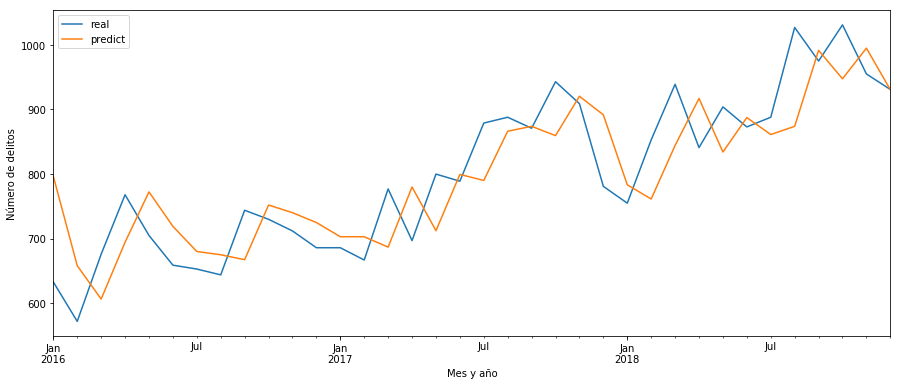

In [13]:
#generamos la predicción
pred_future = results.predict(start = pd.to_datetime('2016-01-01'), end = pd.to_datetime('2018-12-01'), dynamic = False)

#graficamos la predicción junto con los valores reales
time_pd.plot(figsize = (15, 6), label = 'datos')
pred_future.plot(label = 'predict')
plt.ylabel('Número de delitos')

L = plt.legend()
L.get_texts()[0].set_text('real')

ARIMA

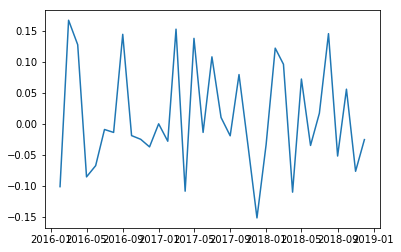

In [14]:
import numpy as np

ts = time_pd['count']#nuevo dataframe a partir de columna count
ts.head()
ts_log = np.log(ts)#cambiar escala a logarítmica
ts_log_diff = ts_log - ts_log.shift()#normalización de datos
plt.plot(ts_log_diff)

In [15]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
p = d = q = range(0, 4)#definir d para la parte de integración del modelo
pq = list(itertools.product(p, d, q))#generar la lista de combinaciones posibles
for param in pq:#imprimir AIC del modelo (seleccionar el menor valor y obtener un mejor modelo)
    try:
        mod = ARIMA(ts_log, order = param)
        results_test = mod.fit()
        print("ARIMA{}: - AIC:{}".format(param, results_test.aic))
    except:
        continue

ARIMA(0, 0, 0): - AIC:-29.83249514279383
ARIMA(0, 0, 1): - AIC:-49.364223795961365
ARIMA(0, 0, 2): - AIC:-57.91104987570732
ARIMA(0, 0, 3): - AIC:-59.78874770814427
ARIMA(0, 1, 0): - AIC:-68.1108235582322
ARIMA(0, 1, 1): - AIC:-74.32477328136642
ARIMA(0, 1, 2): - AIC:-76.28374313975257
ARIMA(0, 1, 3): - AIC:-74.48878591928207
ARIMA(0, 2, 0): - AIC:-34.62028816445144
ARIMA(0, 2, 1): - AIC:-59.55595444041762
ARIMA(0, 2, 2): - AIC:-60.71495671862789
ARIMA(1, 0, 0): - AIC:-68.93283949140549
ARIMA(1, 0, 1): - AIC:-25.856489272646982
ARIMA(1, 0, 2): - AIC:-45.398683188143835
ARIMA(1, 1, 0): - AIC:-68.46156657263828
ARIMA(1, 1, 1): - AIC:-76.06501620382403
ARIMA(1, 2, 0): - AIC:-44.64266930242567
ARIMA(1, 2, 1): - AIC:-59.4804511779696
ARIMA(2, 0, 0): - AIC:-67.62395435044014
ARIMA(2, 0, 1): - AIC:-66.75739312880735
ARIMA(2, 0, 2): - AIC:-64.9451353768737
ARIMA(2, 0, 3): - AIC:-67.25366754568189
ARIMA(2, 1, 0): - AIC:-67.83964325076428
ARIMA(2, 1, 1): - AIC:-74.66497012680739
ARIMA(2, 2, 0): 

In [16]:
model_arima = ARIMA(ts_log, order = (0, 1, 2))#ajustamos el modelo con el mejor valor AIC
results_arima = model_arima.fit()
print(results_arima.summary2())#mostramos los resultados para ARIMA

                           Results: ARIMA
Model:              ARIMA            BIC:                 -70.0624  
Dependent Variable: D.count          Log-Likelihood:      42.142    
Date:               2019-04-13 10:35 Scale:               1.0000    
No. Observations:   35               Method:              css-mle   
Df Model:           3                Sample:              02-01-2016
Df Residuals:       32                                    12-01-2018
Converged:          1.0000           S.D. of innovations: 0.069     
No. Iterations:     12.0000          HQIC:                -74.136   
AIC:                -76.2837                                        
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const             0.0127    0.0014   8.7480  0.0000   0.0098   0.0155
ma.L1.D.count    -0.6724    0.1682  -3.9989  0.0004  -1.0

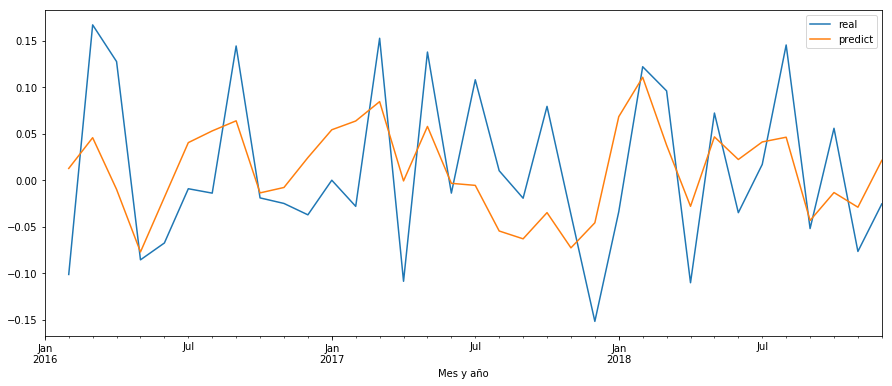

In [17]:
#generamos la predicción
pred_future_arima = results_arima.predict(start = pd.to_datetime('2016-02-01'), end = pd.to_datetime('2018-12-01'), dynamic = False)

#graficamos la predicción junto con los valores reales
ts_log_diff.plot(figsize = (15, 6), label = 'datos')
pred_future_arima.plot(label = 'predict')

L = plt.legend()
L.get_texts()[0].set_text('real')

In [18]:
predictions_arima_diff = pd.Series(results_arima.fittedvalues, copy = True)
predictions_arima_diff_cumsum = predictions_arima_diff.cumsum()#suma acumulativa de los valores
predictions_arima_log = pd.Series(ts_log.ix[0], index = ts_log.index)
predictions_arima_log = predictions_arima_log.add(predictions_arima_diff_cumsum, fill_value = 0)
prediction = np.exp(predictions_arima_log)#tomamos el exponente
prediction.head()

Mes y año
2016-01-01    633.000000
2016-02-01    641.077713
2016-03-01    671.080597
2016-04-01    664.506970
2016-05-01    615.190020
dtype: float64

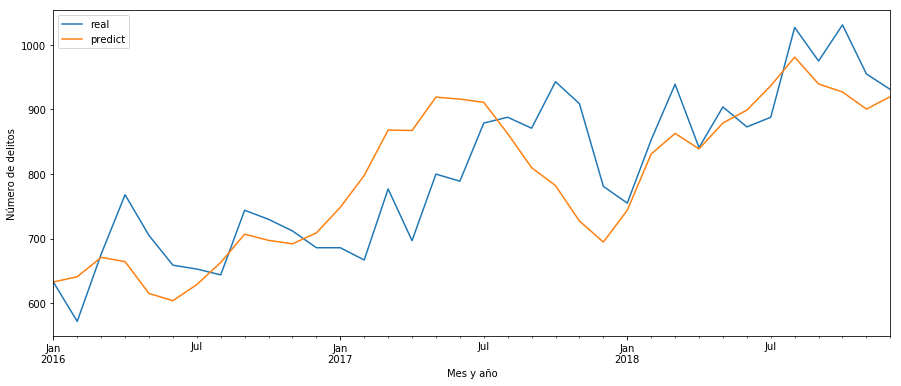

In [19]:
#graficamos los valores en su escala original
time_pd.plot(figsize = (15, 6), label = 'datos')
prediction.plot(label = 'predict')
plt.ylabel('Número de delitos')

L = plt.legend()
L.get_texts()[0].set_text('real')

SARIMA

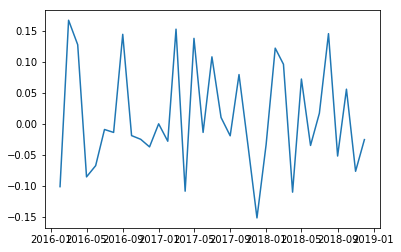

In [21]:
import numpy as np

ts = time_pd['count']#nuevo dataframe a partir de count
ts.head()
ts_log = np.log(ts)#cambiar a escala logarítmica
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))#lista de combinaciones posibles
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Combinación de parámetros SARIMAX')
print('SARIMAX: {} X {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} X {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} X {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} X {}'.format(pdq[2], seasonal_pdq[4]))

Combinación de parámetros SARIMAX
SARIMAX: (0, 0, 1) X (0, 0, 1, 12)
SARIMAX: (0, 0, 1) X (0, 1, 0, 12)
SARIMAX: (0, 1, 0) X (0, 1, 1, 12)
SARIMAX: (0, 1, 0) X (1, 0, 0, 12)


In [23]:
array1 = []
array2 = []
array3 = []
for param in pdq:#imprimir AIC del modelo para seleccionar el menor valor-> mejor modelo
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(ts_log_diff,
                         order = param,
                         seasonal_order = param_seasonal,
                         enforce_stationarity = False,
                         enforce_invertibility = False)
            results_test = mod.fit()
            
            array1.append(results_test.aic)
            array2.append(param)
            array3.append(param_seasonal)
        except:
            continue

In [25]:
print("min {}: {}".format(array1.index(min(array1)), min(array1)))
print("SARIMA{}x{}".format(array2[array1.index(min(array1))], array3[array1.index(min(array1))]))

min 0: -69.54540003782881
SARIMA(0, 0, 0)x(0, 0, 0, 12)


In [26]:
model_sarima = SARIMAX(ts_log_diff,
                      order = (0, 0, 0),
                      seasonal_order = (0, 0, 0, 12),
                      enforce_stationarity = False,
                      enforce_invertibility = False)
results_sarima = model_sarima.fit()
print(results_sarima.summary())

                           Statespace Model Results                           
Dep. Variable:                  count   No. Observations:                   36
Model:                        SARIMAX   Log Likelihood                  35.773
Date:                Sat, 13 Apr 2019   AIC                            -69.545
Time:                        10:54:50   BIC                            -67.990
Sample:                    01-01-2016   HQIC                           -69.008
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0076      0.002      3.220      0.001       0.003       0.012
Ljung-Box (Q):                       35.85   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.38   Pr

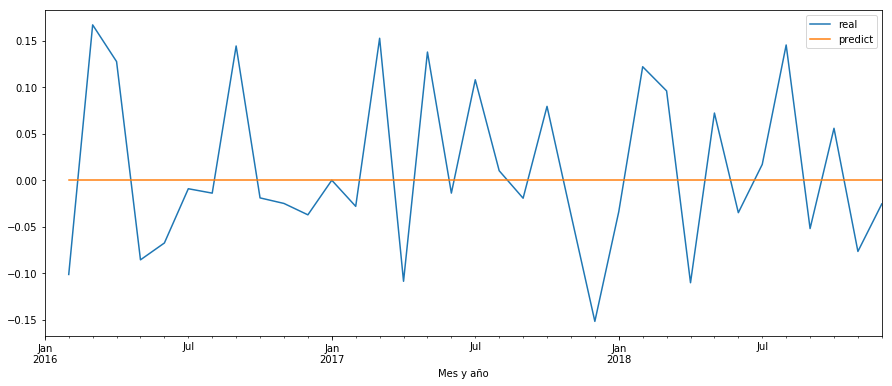

In [27]:
#generamos la predicción
pred_future_sarima = results_sarima.predict(start = pd.to_datetime('2016-02-01'), end = pd.to_datetime('2018-12-01'), dynamic = False)

#graficar predicción junto con vaores reales
ts_log_diff.plot(figsize = (15, 6), label = 'datos')
pred_future_sarima.plot(label = 'predict')

L = plt.legend()
L.get_texts()[0].set_text('real')

SES

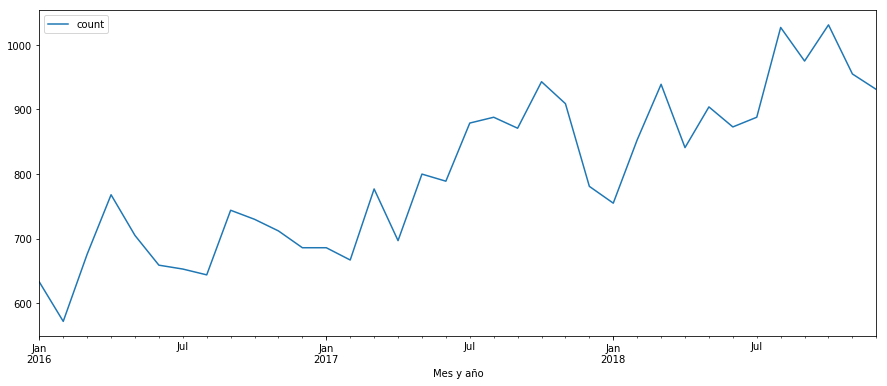

In [28]:
import matplotlib.pyplot as plt

time_pd.plot(figsize = (15, 6))
plt.show()

In [29]:
time_pd.tail()

,count
Mes y año,
2018-08-01,1027
2018-09-01,975
2018-10-01,1031
2018-11-01,955
2018-12-01,931


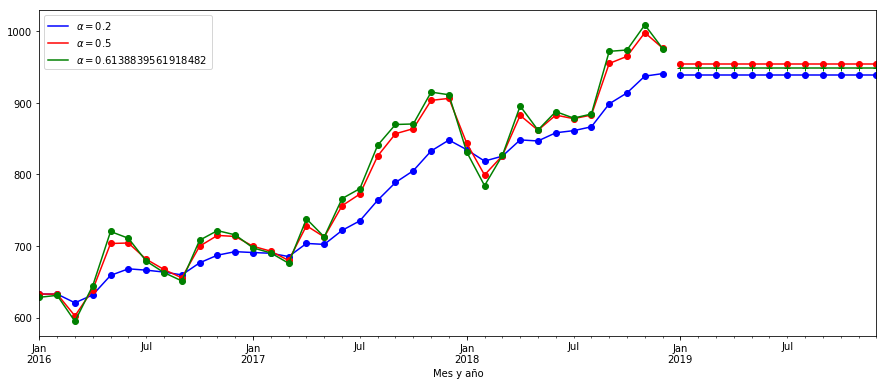

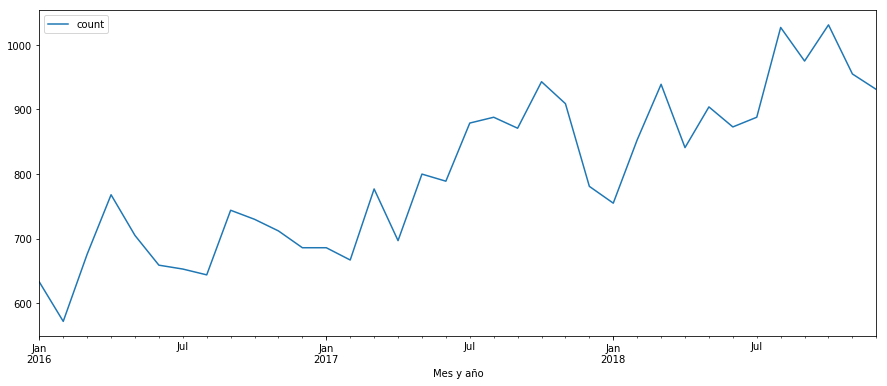

In [30]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import statsmodels.api as sm

fit1 = SimpleExpSmoothing(time_pd).fit(smoothing_level = 0.2, optimized = False)#entrenamiento 0.2
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')#predicción con alpha 0.2
#plot
fcast1.plot(marker = 'o', color = 'blue', legend = True, figsize = (15, 6))
fit1.fittedvalues.plot(marker = 'o', color = 'blue')


fit2 = SimpleExpSmoothing(time_pd).fit(smoothing_level = 0.5, optimized = False)#entrenamiento 0.5
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.5$')#predicción con alpha 0.5
#plot
fcast2.plot(marker = 'o', color = 'red', legend = True, figsize = (15, 6))
fit2.fittedvalues.plot(marker = 'o', color = 'red')

fit3 = SimpleExpSmoothing(time_pd).fit()#entrenamiento ajusta alfa óptima
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
#plot
fcast3.plot(marker = '+', color = 'green', legend = True, figsize = (15, 6))
fit3.fittedvalues.plot(marker = 'o', color = 'green')

time_pd.plot(figsize = (15, 6), legend = 'Serie de tiempo')
plt.show()